## Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in pythong using a few different techniques:

1. VADER (Valence Aware Dictionary and sEntiment Reasoner)
1. Roberta Pretrained Model from Hugging Face
1. Huggingface Pipeline

### Step 0. Read in Data and NLTK Basics

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import word_tokenize, sent_tokenize, pos_tag

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\teddi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\teddi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [62]:
# Read in data
df = pd.read_csv('sampled_data.csv')
df.reset_index(inplace=True, drop=True)
print(df.shape)


(500, 10)


In [63]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,125114,B000NY8OLK,A1I0PEMIH7L8Q,leo,10,10,1,1288310400,New recipe made in USA,Other reviewers have already said that the Lin...
1,16352,B007TJGZ54,ABYVECXXSP6R5,Lapimienta,0,0,5,1280707200,Excellent-love it!,This is the best k-cup coffee I've had. Its b...
2,25919,B000EVMNNC,A1JJ0QZIEENQ05,kms,0,2,3,1210636800,ok - but in small portions only,I completely liked these things --- BEFORE I g...
3,493952,B001F3HD06,A1CTTFNLP7MRYB,Dustin,0,0,5,1345161600,Good in Beer Too!!!,"First of all, I want to start off by saying th..."
4,223426,B002QGK2V8,A2MIUU3BJO38YJ,Ladner D. Brown,1,1,4,1259280000,"Smooth, creamy and interesting",I just received my box of Kahula and it wasn't...


#### Quick EDA

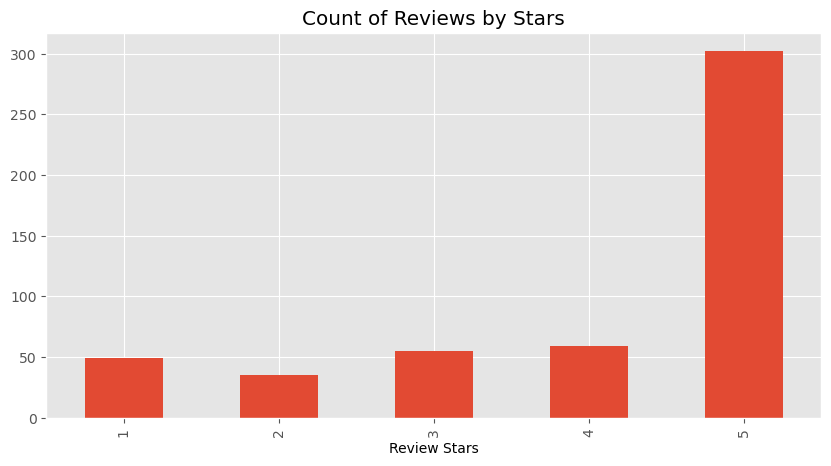

In [64]:
ax = df['Score'].value_counts().sort_index() \
    .plot.bar(title='Count of Reviews by Stars', 
              figsize=(10, 5))
ax.set_xlabel('Review Stars')

plt.show()

## Basic NLTK

In [65]:
example = df['Text'][50]
print(example)

These are great.  I like the fact that they are in portion controlled bags which make them easy to throw in a book bag, carry-on bag or lunch box.  They are a bit hard so they don't crumble easily before you get to them.  The taste is similar to cinammon graham crackers.


In [66]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['These', 'are', 'great', '.', 'I', 'like', 'the', 'fact', 'that', 'they']

In [67]:
# Find part of speech
tagged = nltk.pos_tag(tokens) # see POS abbreviations and meanings at https://www.guru99.com/pos-tagging-chunking-nltk.html#1
tagged[:10]

[('These', 'DT'),
 ('are', 'VBP'),
 ('great', 'JJ'),
 ('.', '.'),
 ('I', 'PRP'),
 ('like', 'IN'),
 ('the', 'DT'),
 ('fact', 'NN'),
 ('that', 'IN'),
 ('they', 'PRP')]

In [68]:
# Next, lets take the POS tags and put into entities
entities = nltk.ne_chunk(tagged)
entities.pprint()

(S
  These/DT
  are/VBP
  great/JJ
  ./.
  I/PRP
  like/IN
  the/DT
  fact/NN
  that/IN
  they/PRP
  are/VBP
  in/IN
  portion/NN
  controlled/VBN
  bags/NNS
  which/WDT
  make/VBP
  them/PRP
  easy/JJ
  to/TO
  throw/VB
  in/IN
  a/DT
  book/NN
  bag/NN
  ,/,
  carry-on/JJ
  bag/NN
  or/CC
  lunch/NN
  box/NN
  ./.
  They/PRP
  are/VBP
  a/DT
  bit/RB
  hard/JJ
  so/IN
  they/PRP
  do/VBP
  n't/RB
  crumble/VB
  easily/RB
  before/IN
  you/PRP
  get/VBP
  to/TO
  them/PRP
  ./.
  The/DT
  taste/NN
  is/VBZ
  similar/JJ
  to/TO
  cinammon/VB
  graham/JJ
  crackers/NNS
  ./.)


### Step 1. VADER Sentiment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the negative/neutral/postive scores of the text.

* This uses a "bag of words" approach:
    1. Stop words are removed
    1. Each word is scored and combined to a total score.

Note: This approach does not account for relationship between words.

In [69]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [70]:
# Create a function to get the polarity score for a given sentence
sia.polarity_scores('I am so happy to be coding with you all today!') # returns a dictionary of scores'

{'neg': 0.0, 'neu': 0.677, 'pos': 0.323, 'compound': 0.6468}

In [71]:
sia.polarity_scores('This is worst time of night to be coding.') # compound score range is -1 (neg) to 1 (pos)

{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}

In [72]:
sia.polarity_scores(example)['compound']

0.7943

In [73]:
sia.polarity_scores(example)

{'neg': 0.06, 'neu': 0.773, 'pos': 0.167, 'compound': 0.7943}

In [74]:
# Run the polarity score on all reviews
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)
    








100%|██████████| 500/500 [00:00<00:00, 740.86it/s]


In [75]:
# Lets store and view the results in a df
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left', on='Id')

    


In [76]:
# Now we have sentiment scores  and metadata for each review
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,125114,0.117,0.773,0.110,-0.1759,B000NY8OLK,A1I0PEMIH7L8Q,leo,10,10,1,1288310400,New recipe made in USA,Other reviewers have already said that the Lin...
1,16352,0.000,0.520,0.480,0.9690,B007TJGZ54,ABYVECXXSP6R5,Lapimienta,0,0,5,1280707200,Excellent-love it!,This is the best k-cup coffee I've had. Its b...
2,25919,0.164,0.733,0.103,-0.7102,B000EVMNNC,A1JJ0QZIEENQ05,kms,0,2,3,1210636800,ok - but in small portions only,I completely liked these things --- BEFORE I g...
3,493952,0.022,0.725,0.254,0.9740,B001F3HD06,A1CTTFNLP7MRYB,Dustin,0,0,5,1345161600,Good in Beer Too!!!,"First of all, I want to start off by saying th..."
4,223426,0.035,0.672,0.293,0.9695,B002QGK2V8,A2MIUU3BJO38YJ,Ladner D. Brown,1,1,4,1259280000,"Smooth, creamy and interesting",I just received my box of Kahula and it wasn't...


#### Plot VADER Results

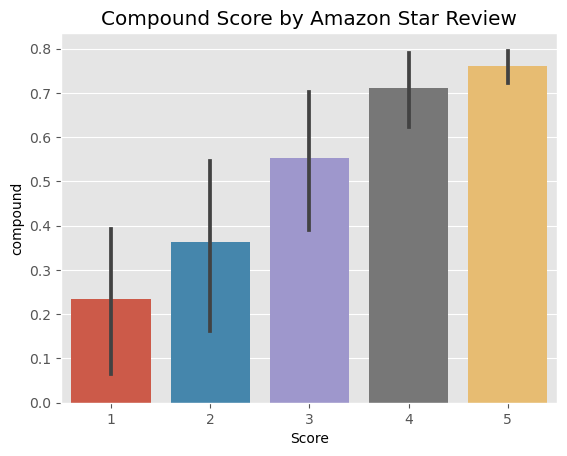

In [60]:
# Lets assume that a score of 5 is a positive review and a score of 1 is a negative review
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')

plt.show()